<a href="https://colab.research.google.com/github/Primary43/CustomerSegmentation-Plotly-Dash/blob/main/Clustering_Plotly_Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Customer Segmentation----------------------------------**

Task 1: Data Loading and data exploration
- 1.1 Data Import/ Inspeaction/ Data Cleaning
- 1.2 Exploratory Analysis 
- 1.3 Feature Engineering/ Feature Transformation/ PCA

Task 2: Clustering
- 2.1 KMean
- 2.2 DBSCANS

Task 3: Model Selection and Analysis

Task 4: Dash Plotly Dashboard

Task 5: Deploy WebApps using ngrok


In [32]:
!pip install jupyter-dash -q
!pip install dash-bootstrap-components
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 KB 3.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
to-requirements-txt 1.3.0 requires click==8.0.3, but you have click 7.1.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
pd.set_option('display.max_rows', 10)

#plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

#dash
from jupyter_dash import JupyterDash  
from dash.dependencies import Output, Input, State
import plotly.express as px
from dash import no_update
import dash_bootstrap_components as dbc
import dash_html_components as html
import dash_core_components as dcc

Task 1: Data Loading and data exploration
- 1.1 Data Import/ Inspeaction/ Data Cleaning

In [34]:
df = pd.read_csv('https://raw.githubusercontent.com/Primary43/CustomerSegmentation-Plotly-Dash/main/customers.csv')
#Data Inspection
print('Task 1.1: Data Inspection\n')
print(df.info()) #5 columns in total, 4 are numeric only gender column is catagorical
#all contain non-null
print('*'*50)
print(df.head())
print(df.tail())
print('*'*50)
print(df.describe())
print('*'*100)

print('Task 1.2: Data Cleaning\n')
print('missing value: ', df.isnull().any(axis=1).sum())# no missing
print('duplicated value: ', df.duplicated().sum()) #no duplicated value
print('*'*50)
#Rename column
#print('Rename Columns')
df = df.rename(columns={'Annual Income (k$)': 'Annual_Income',
                       'Spending Score (1-100)': 'Spending_Score'})
print(df)
print('*'*50)

#transform catagorical into numerical 
print('Transform catagorical into numerical: ')
gender= {'Male':0, 'Female':1}
df_encode = df.copy()
df_encode['Gender']= df_encode['Gender'].map(gender)
print('Gender Index: ', df_encode['Gender'].unique())#
print(df_encode.head())

Task 1.1: Data Inspection

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
**************************************************
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  

- 1.2 Exploratory Analysis 


In [35]:
print('Task 1.2: Exploratory Analysis \n')

#data distribution
print('Data Distribution:')

#seperate gender from other features
df_no_gender = df.drop(['Gender'], axis=1)
df_gender = pd.concat([df_no_gender,df['Gender']], axis = 1)
df_feature = pd.melt(df_gender, 'Gender', var_name="features")

#1-pie plot
fig1 = px.pie(df, names='Gender',color_discrete_sequence=[
                 'orange', 'blue'], hole = 0.3)
fig1.show()
    
#2-violin plot
fig2 = go.Figure()
fig2.add_trace(go.Violin(x=df_feature['features'][ df_feature['Gender'] == 'Female' ],
                        y=df_feature['value'][ df_feature['Gender'] == 'Female' ],
                        legendgroup='Female', scalegroup='Female', name='Female',
                        side='positive',
                        line_color='orange')
             )
fig2.add_trace(go.Violin(x=df_feature['features'][ df_feature['Gender'] == 'Male' ],
                        y=df_feature['value'][ df_feature['Gender'] == 'Male' ],
                        legendgroup='Male', scalegroup='Male', name='Male',
                        side='negative',
                        line_color='blue')
             )
fig2.update_traces(meanline_visible=True)
fig2.update_layout(violingap=0, violinmode='overlay')
fig2.show()
#no significant in median of ages, annual income and spending score between gender
#median of male's age and annual income is slightly higher than female

#3-scatter plot
fig3 = ff.create_scatterplotmatrix(df, diag='histogram', index='Gender',
                                  height=500, width=800, 
                                  colormap= dict(
                                      Female = '#FF9900',
                                      Male = '#1616A7'),
                                  colormap_type='cat',
                                  marker=dict(line_color='white', line_width=0.5)
                                  )
fig3.update_layout(hovermode='closest')
fig3.show()

#mean:  age: 38.85, annual income:60.56, Spending score:50.20
#majority of customaers'age is 30-35 years, following by below 20 year, 45-50 years old.
#majority of customaers' income is 50-62.5K, following by 75-87.5k
#majority of customaers' spending score is 50-60, following by 40-50 scores


#4correlation plot
print('Data Correlation:')
df_corr = df_encode.corr().round(2)
mask = np.triu(np.ones_like(df_corr, dtype=bool))
fig4 = go.Figure()
fig4.add_trace(go.Heatmap(
    x=list(df_corr.index.values),
    y=list(df_corr.columns.values),
    z= df_corr.mask(mask).to_numpy(),
    colorscale=px.colors.diverging.RdBu
    ))
fig4.update_layout(yaxis_autorange='reversed')
fig4.show()
#there are high positive correlation between CustomerID-Annual Income (0.98)
#and negative correlation between Ages-Spending Scores(-0.33)
#there is no significane in other features

Task 1.2: Exploratory Analysis 

Data Distribution:


Data Correlation:


In [36]:
df

,CustomerID,Gender,Age,Annual_Income,Spending_Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


 1.3 Feature Engineering
- Feature Transformation
- PCA

Standardisation:
      Annual_Income           Age  Spending_Score
mean  -2.131628e-16 -1.021405e-16   -1.465494e-16
std    1.002509e+00  1.002509e+00    1.002509e+00
   Annual_Income       Age  Spending_Score  Gender
0      -1.738999 -1.424569       -0.434801       0
1      -1.738999 -1.281035        1.195704       0
2      -1.700830 -1.352802       -1.715913       1
3      -1.700830 -1.137502        1.040418       1
4      -1.662660 -0.563369       -0.395980       1
**************************************************


MinMaxScaler:
      Annual_Income       Age  Spending_Score    Gender
mean       0.373443  0.400962        0.502041  0.560000
std        0.215285  0.268635        0.263505  0.497633
   Annual_Income       Age  Spending_Score  Gender
0       0.000000  0.019231        0.387755       0
1       0.000000  0.057692        0.816327       0
2       0.008197  0.038462        0.051020       1
3       0.008197  0.096154        0.775510       1
4       0.016393  0.250000        0.3

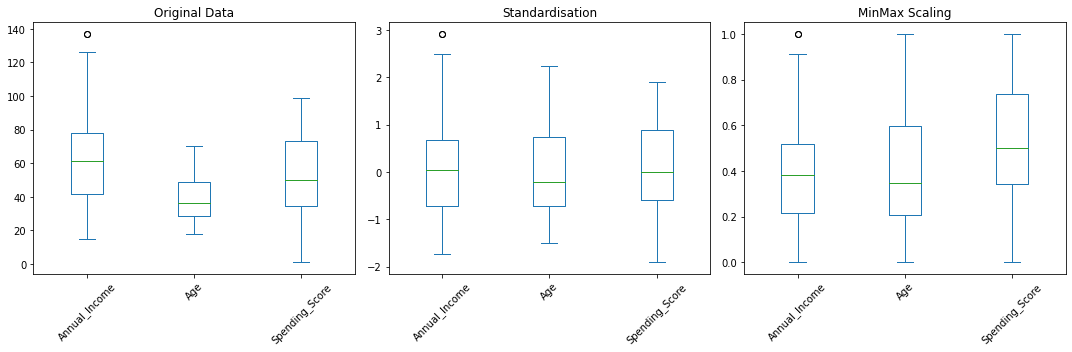

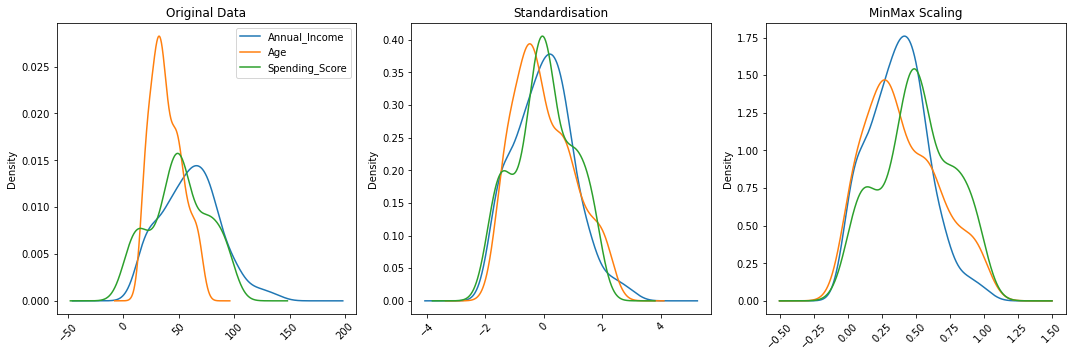

   Gender  Age  Annual_Income  Spending_Score
0       0   19             15              39
1       0   21             15              81
2       1   20             16               6
3       1   23             16              77
4       1   31             17              40
Feature Selection:


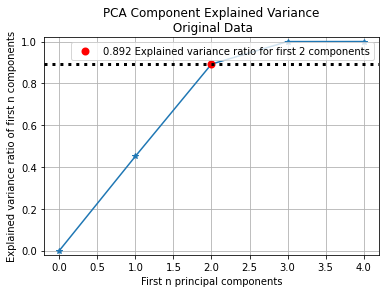

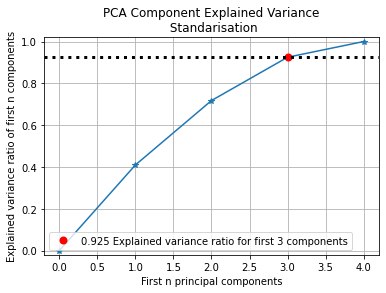

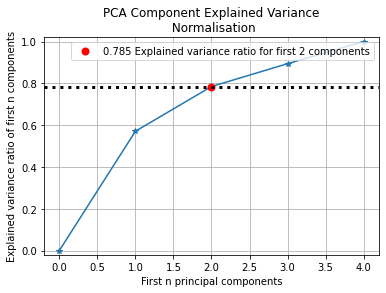

<Figure size 432x288 with 0 Axes>

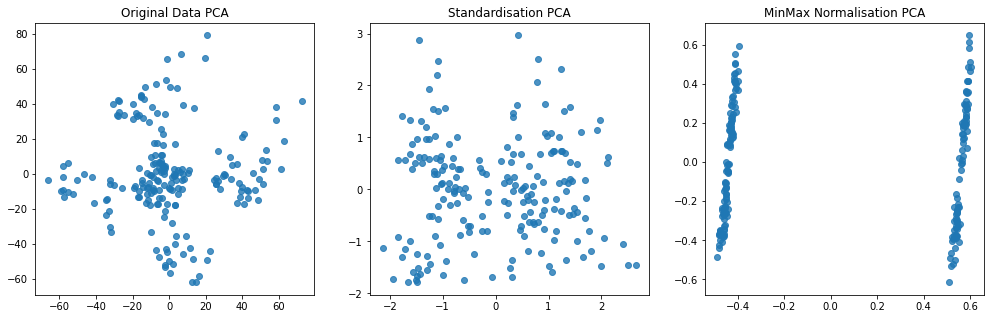

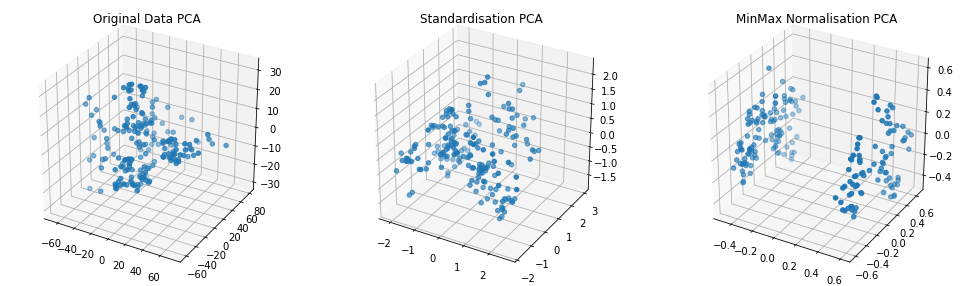

In [37]:
#Standardisation (Z-score normalisation) to re-scale zero mean/ 1std
# to have  same mean and variance
print('Standardisation:')
col_nm = ['Annual_Income', 'Age', 'Spending_Score'] #only numeric value
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
standardized_df = scaler1.fit(df_encode[col_nm]).transform(df_encode[col_nm])
standardized_df = pd.DataFrame(standardized_df, columns = col_nm)
print(standardized_df.describe().loc[['mean','std'],:])
standardized_df = standardized_df.join(df_encode['Gender'])
print(standardized_df.head())
print('*'*50)
print('\n')

#Normalisation - MinMaxScaler into range 0,1
print('MinMaxScaler:')
from sklearn.preprocessing import MinMaxScaler
scaler2 = MinMaxScaler(feature_range = (0, 1)) # to make it range between 1 and 5
minmax_df = scaler2.fit(df_encode[col_nm].values).transform(df_encode[col_nm].values)
minmax_df = pd.DataFrame(minmax_df, columns = col_nm)
minmax_df = minmax_df.join(df_encode['Gender'])
print( minmax_df.describe().loc[['mean','std'],:])
print(minmax_df.head())
print('*'*50)

fig, ax = plt.subplots(1, 3, figsize=(15,5))
pd.DataFrame(df_encode[['Annual_Income','Age','Spending_Score']]).plot(kind='box', legend = True, rot = 45, ax=ax[0], title='Original Data')
pd.DataFrame(standardized_df[['Annual_Income','Age','Spending_Score']]).plot(kind='box', legend = False, rot = 45, ax=ax[1], title='Standardisation')
pd.DataFrame(minmax_df[['Annual_Income','Age','Spending_Score']]).plot(kind='box', legend = False, rot = 45, ax=ax[2], title='MinMax Scaling')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(15,5))
pd.DataFrame(df_encode[['Annual_Income','Age','Spending_Score']]).plot(kind='kde', legend = True, rot = 45, ax=ax[0], title='Original Data')
pd.DataFrame(standardized_df[['Annual_Income','Age','Spending_Score']]).plot(kind='kde', legend = False, rot = 45, ax=ax[1], title='Standardisation')
pd.DataFrame(minmax_df[['Annual_Income','Age','Spending_Score']]).plot(kind='kde', legend = False, rot = 45, ax=ax[2], title='MinMax Scaling')
plt.tight_layout()
plt.show()

df_encode = df_encode.copy()
df_encode = df_encode.loc[:, df_encode.columns != 'CustomerID']
print(df_encode.head())


print('Feature Selection:')
#dimensionality reduction (PCA) Principle Component Analysis 
#not scaling
import scikitplot as skplt
pca = PCA(random_state=1)
pca.fit(df_encode)
skplt.decomposition.plot_pca_component_variance(pca)
plt.title('PCA Component Explained Variance\n Original Data')
plt.show()

#Standardisation
pca = PCA(random_state=1)
pca.fit(standardized_df)
skplt.decomposition.plot_pca_component_variance(pca)
plt.title('PCA Component Explained Variance\n Standarisation')
plt.show()

#Normalisation
pca = PCA(random_state=1)
pca.fit(minmax_df)
skplt.decomposition.plot_pca_component_variance(pca)
plt.title('PCA Component Explained Variance\n Normalisation')
plt.show()


#evaluate the usefulness of  principal components using explained variance of each number of the component--- https://towardsdatascience.com/dealing-with-highly-dimensional-data-using-principal-component-analysis-pca-fea1ca817fe6
#reduce the dimension of a dataset
#only 2-3 dimensionality matters
pca = PCA(n_components=3)
df_PCA = pca.fit_transform(df_encode)
PCA_df = pd.DataFrame(data = df_PCA, columns = ['PCA1', 'PCA2','PCA3'])

pca = PCA(n_components=3)
df_PCA_mm = pca.fit_transform(minmax_df)
PCA_df_mm = pd.DataFrame(data = df_PCA_mm,  columns = ['PCA1', 'PCA2','PCA3'])

pca = PCA(n_components=3)
df_PCA_std = pca.fit_transform(standardized_df)
PCA_df_std = pd.DataFrame(data = df_PCA_std,  columns = ['PCA1', 'PCA2','PCA3'])
#print(PCA_df_std.head())

#plot 2PCA
f = plt.figure()    
f, axes = plt.subplots(nrows = 1, ncols = 3,figsize=(17,5))
axes[0].scatter(PCA_df['PCA1'], PCA_df['PCA2'], alpha = 0.8)
axes[0].set_title('Original Data PCA')
axes[1].scatter(PCA_df_std['PCA1'], PCA_df_std['PCA2'], alpha = 0.8)
#axes[1].set_xlabel('Standardisation', labelpad = 5)
axes[1].set_title('Standardisation PCA')
axes[2].scatter(PCA_df_mm['PCA1'], PCA_df_mm['PCA2'], alpha = 0.8)
axes[2].set_title('MinMax Normalisation PCA')
plt.show()

#plot 3PCA
fig = plt.figure(figsize=(17,5))
#ax = plt.axes(projection ="3d")
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.scatter3D(PCA_df['PCA1'], PCA_df['PCA2'],PCA_df['PCA3'])
ax.set_title('Original Data PCA')
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.scatter3D(PCA_df_std['PCA1'], PCA_df_std['PCA2'],PCA_df_std['PCA3'])
ax.set_title('Standardisation PCA')
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter3D(PCA_df_mm['PCA1'], PCA_df_mm['PCA2'],PCA_df_mm['PCA3'])
ax.set_title('MinMax Normalisation PCA')
plt.show()

Task 2: Clustering
- 2.1 *Kmean*

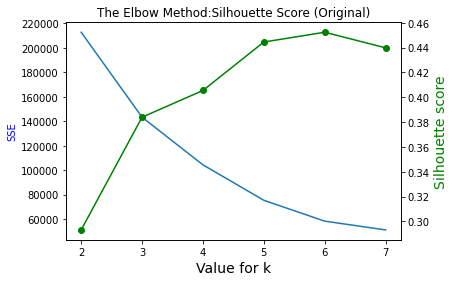

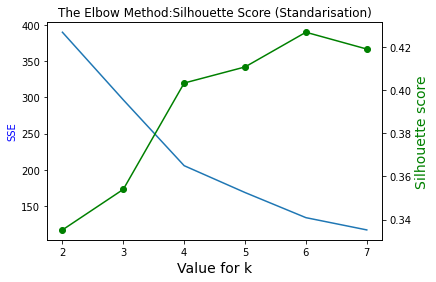

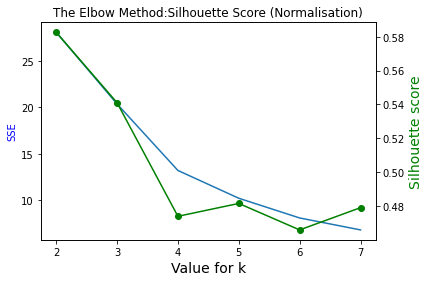

        PCA1       PCA2       PCA3  label
0 -31.869945 -33.001252 -22.142987      1
1   0.764494 -56.842901 -10.542634      4
2 -57.408276 -13.124961 -28.750964      1
3  -2.168543 -53.478590  -9.511588      4
4 -32.174085 -30.388412 -10.225069      1
silhouette_score:  0.44
       PCA1      PCA2      PCA3  label
0 -0.600438 -1.737179  1.322247      1
1 -1.649886 -1.789124  0.067789      1
2  0.315381 -1.692772  2.179818      1
3 -1.477989 -1.781317  0.078518      1
4 -0.060545 -1.678691  0.688083      1
silhouette_score:  0.48
       PCA1      PCA2      PCA3  label
0  0.532955 -0.227841  0.321860      2
1  0.513939 -0.493080 -0.016202      2
2 -0.446266  0.087079  0.555761      3
3 -0.478796 -0.366617 -0.010714      0
4 -0.451984  0.003006  0.159208      0
silhouette_score:  0.77


<Figure size 432x288 with 0 Axes>

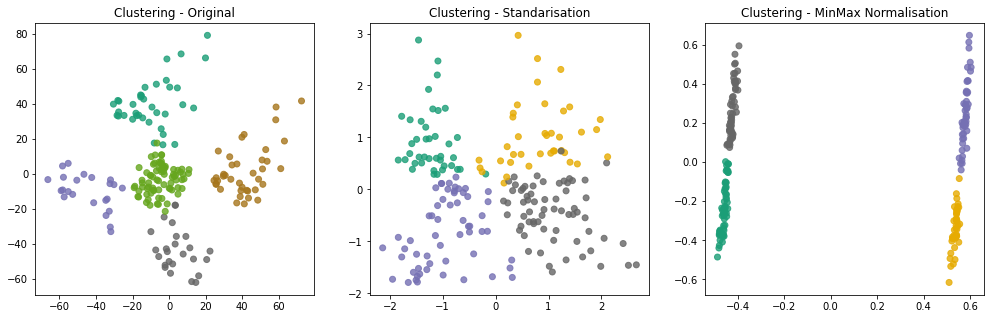

Text(0.5, 0.92, 'Clustering - MinMax Normalisation \n silhouette_score: 0.77')

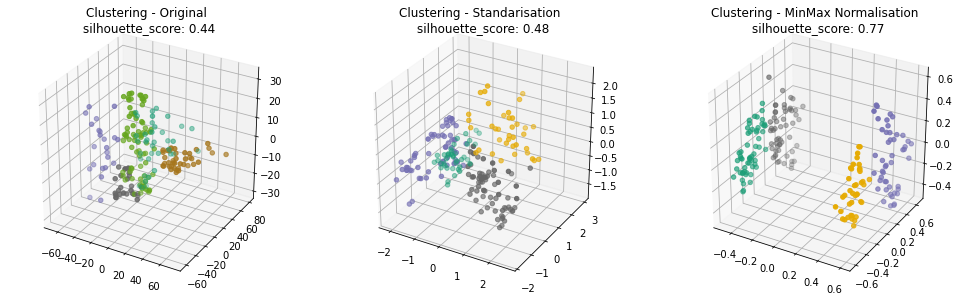

In [38]:
#kmean
#calculate the distance to the centroid of each cluster
#each data point is assigned in one cluster by the closest centroid (minimise sum of distance)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#K-hyperparameter - optimal number of clusters in K-means clustering.
#Elbow method and SSE plot: reduction of variation vs number of cluster, when the data become linear manner
#SSE or Inertia : within-cluster sum of square error calculated using Euclidean distance https://vitalflux.com/k-means-elbow-point-method-sse-inertia-plot-python/
#not scaling
k = [2, 3, 4, 5, 6, 7]
sse = []
for i in k:
    km = KMeans(n_clusters=i, init = 'k-means++', random_state = 42)
    km.fit(PCA_df)
    sse.append(km.inertia_)
#use silhouette coefficient for validate measure quality of the clusters 
#evaluating a separation distance between datapoint and its closest cluster (the higher score, the better result (-1,1))
score=[]
for n_cluster in k:
    kmeans = KMeans(n_clusters=n_cluster, init = 'k-means++', random_state = 42)
    kmeans.fit(PCA_df)
    silhouette_avg = silhouette_score(PCA_df,kmeans.labels_)
    score.append(silhouette_score(PCA_df,kmeans.labels_))
    #print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))
fig,ax = plt.subplots()
ax.plot(k, sse)
ax.set_xlabel('Value for k',fontsize=14)
ax.set_ylabel('SSE',color="blue")
ax.set_title('The Elbow Method:Silhouette Score (Original)')
ax1=ax.twinx()
ax1.plot(k, score, 'o-',color='green')
ax1.set_ylabel('Silhouette score',color="green",fontsize=14)
plt.show()
#the best K-vale = 5

#Standardisation
k = [2, 3, 4, 5, 6, 7]
sse = []
for i in k:
    km = KMeans(n_clusters=i, init = 'k-means++', random_state = 42)
    km.fit(PCA_df_std)
    sse.append(km.inertia_)
score=[]
for n_cluster in k:
    kmeans = KMeans(n_clusters=n_cluster, init = 'k-means++', random_state = 42)
    kmeans.fit(PCA_df_std)
    silhouette_avg = silhouette_score(PCA_df_std,kmeans.labels_)
    score.append(silhouette_score(PCA_df_std,kmeans.labels_))
    #print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg)) 
fig,ax = plt.subplots()
ax.plot(k, sse)
ax.set_xlabel('Value for k',fontsize=14)
ax.set_ylabel('SSE',color="blue")
ax.set_title('The Elbow Method:Silhouette Score (Standarisation)')
ax1=ax.twinx()
ax1.plot(k, score, 'o-',color='green')
ax1.set_ylabel('Silhouette score',color="green",fontsize=14)
plt.show() #plot combination for more confident decision
#the best K-vale = 4

#normalisation
k = [2, 3, 4, 5, 6, 7]
sse = []
for i in k:
    km = KMeans(n_clusters=i, init = 'k-means++', random_state = 42)
    km.fit(PCA_df_mm)
    sse.append(km.inertia_)
score=[]
for n_cluster in k:
    kmeans = KMeans(n_clusters=n_cluster, init = 'k-means++', random_state = 42)
    kmeans.fit(PCA_df_mm)
    silhouette_avg = silhouette_score(PCA_df_mm,kmeans.labels_)
    score.append(silhouette_score(PCA_df_mm,kmeans.labels_))
    #print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))  
fig,ax = plt.subplots()
ax.plot(k, sse)
ax.set_xlabel('Value for k',fontsize=14)
ax.set_ylabel('SSE',color="blue")
ax.set_title('The Elbow Method:Silhouette Score (Normalisation)')
ax1=ax.twinx()
ax1.plot(k, score, 'o-',color='green')
ax1.set_ylabel('Silhouette score',color="green",fontsize=14)
plt.show()
#the best K-vale = 4

from sklearn.cluster import KMeans
KMeans = KMeans(n_clusters=5)
KMeans.fit(PCA_df)
clusters = KMeans.predict(PCA_df)
PCA_df["label"] = clusters
print(PCA_df.head())
score1 = silhouette_score(PCA_df, KMeans.labels_, metric='euclidean')
score1 = "{:.2f}".format(score1)
print('silhouette_score: ', score1)

from sklearn.cluster import KMeans
KMeans = KMeans(n_clusters=4)
KMeans.fit(PCA_df_std)
clusters = KMeans.fit_predict(PCA_df_std)
PCA_df_std["label"] = clusters
print(PCA_df_std.head())
score2 = silhouette_score(PCA_df_std, KMeans.labels_, metric='euclidean')
score2 = "{:.2f}".format(score2)
print('silhouette_score: ', score2)

from sklearn.cluster import KMeans
KMeans = KMeans(n_clusters=4)
KMeans.fit(PCA_df_mm)
clusters = KMeans.fit_predict(PCA_df_mm)
PCA_df_mm["label"] = clusters
Kmean_mm = PCA_df_mm.copy()
print(PCA_df_mm.head())
score3 = silhouette_score(PCA_df_mm, KMeans.labels_, metric='euclidean')
score3 = "{:.2f}".format(score3)
print('silhouette_score: ', score3)
plt.show()

#plot 2PCA
f = plt.figure()    
f, axes = plt.subplots(nrows = 1, ncols = 3,figsize=(17,5))
axes[0].scatter(PCA_df['PCA1'], PCA_df['PCA2'], alpha = 0.8, c=PCA_df['label'],cmap='Dark2')
axes[0].set_title('Clustering - Original')
axes[1].scatter(PCA_df_std['PCA1'], PCA_df_std['PCA2'], alpha = 0.8, c=PCA_df_std['label'],cmap='Dark2')
#axes[1].set_xlabel('Standardisation', labelpad = 5)
axes[1].set_title('Clustering - Standarisation')
axes[2].scatter(PCA_df_mm['PCA1'], PCA_df_mm['PCA2'], alpha = 0.8, c=PCA_df_mm['label'],cmap='Dark2')
axes[2].set_title('Clustering - MinMax Normalisation')
plt.show()

fig = plt.figure(figsize=(17,5))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.scatter3D(PCA_df.PCA1, PCA_df.PCA2 ,PCA_df.PCA3, c=PCA_df['label'], cmap='Dark2')
ax.set_title('Clustering - Original\n silhouette_score: '+ score1)

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.scatter3D(PCA_df_std.PCA1, PCA_df_std.PCA2 ,PCA_df_std.PCA3, c=PCA_df_std['label'], cmap='Dark2')
ax.set_title('Clustering - Standarisation \n silhouette_score: '+ score2)

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter3D(PCA_df_mm.PCA1, PCA_df_mm.PCA2 ,PCA_df_mm.PCA3, c=PCA_df_mm['label'], cmap='Dark2')
ax.set_title('Clustering - MinMax Normalisation \n silhouette_score: '+ score3)

In [39]:
PCA_df_mm_gen = pd.concat([PCA_df_mm, df.Gender], axis = 1)
PCA_df_mm_gen
fig6 = px.scatter_3d(PCA_df_mm_gen, x='PCA1', y='PCA2', z='PCA3',
              color='label', opacity=0.7,
              symbol ='Gender',
              title='Clustering: K-mean<br>Engineering: MinMax Normalisation PCA <br>Silhouette Score: '+ score3)
fig6.update_layout(coloraxis=dict(colorbar=dict(len=0.5)))
fig6.show()

- 2.2 DBSCAN

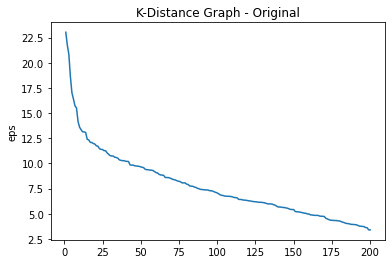

 1    80
-1    62
 2    32
 0    16
 3    10
Name: label, dtype: int64
silhouette_score:  -0.14


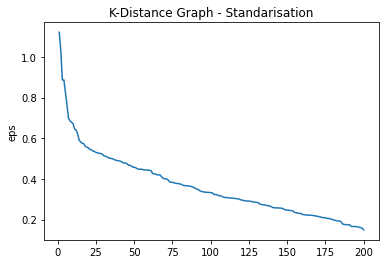

-1    57
 1    51
 3    33
 2    30
 0    19
 4    10
Name: label, dtype: int64
silhouette_score:  0.48


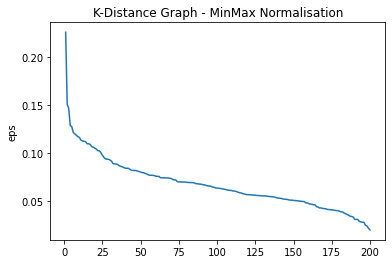

 0    104
 1     37
 2     24
-1     18
 4     11
 3      6
Name: label, dtype: int64
silhouette_score:  0.74


<Figure size 432x288 with 0 Axes>

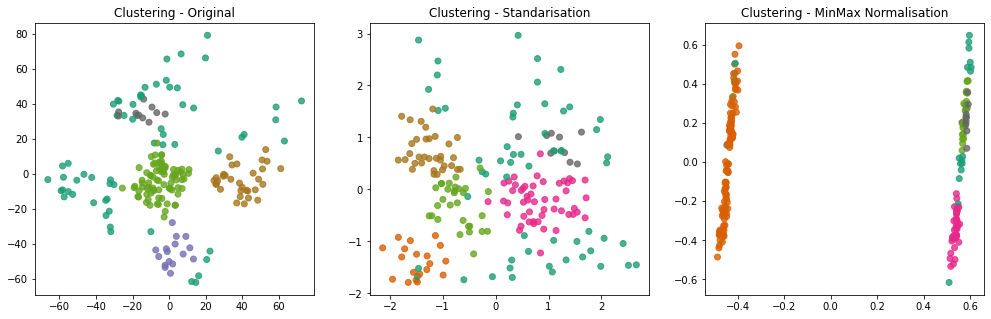

Text(0.5, 0.92, 'Clustering - MinMax Normalisation \n silhouette_score: 0.74')

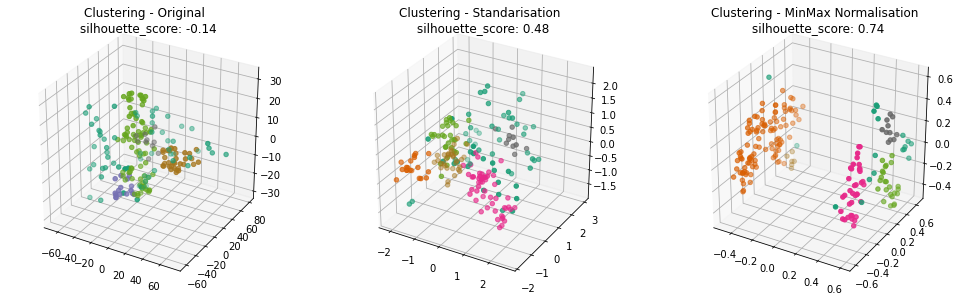

In [40]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

#require domain knowledge of the data set
#minsamples (MinPts ): min nm of data point in dense region or neightborhood to define a cluster
#typically should be >=  the dimensionality of the data set
#If your data has more than 2 dimensions, choose MinPts = 2*dim (Sander et al., 1998)
minPts = 3*2

#epsilon (eps) distance between datapoint and of kth nearest neighbour, determines how close the data point should be the part of cluster (raduis of dense area)
#Use K-distance graph to optimise elbow point 

#not scalling set
PCA_df = PCA_df.iloc[:,:3]
#print(PCA_df)
minPts = 3*2
neighbors = NearestNeighbors(n_neighbors = minPts).fit(PCA_df)
distances, indices = neighbors.kneighbors(PCA_df)
avg_dist = [d.mean() for d in distances]
avg_dist.sort(reverse = True)
plt.plot(list(range(1,PCA_df.shape[0]+1)),avg_dist)
plt.title('K-Distance Graph - Original')
plt.ylabel('eps')
plt.show()
#point of maximum curvature = 11.25
dbscan = DBSCAN(eps=11.25, min_samples=minPts)
dbscan.fit(PCA_df)
PCA_df_kmean = PCA_df.copy()
PCA_df['label'] = dbscan.labels_
print(PCA_df['label'].value_counts())
score4 = silhouette_score(PCA_df_mm,  dbscan.labels_, metric='euclidean')
score4 = "{:.2f}".format(score4)
print('silhouette_score: ', score4)

#Standardisation
from sklearn.neighbors import NearestNeighbors
PCA_df_std = PCA_df_std.iloc[:,:3]
#print(PCA_df_std)
minPts = 3*2
neighbors = NearestNeighbors(n_neighbors = minPts).fit(PCA_df_std)
distances, indices = neighbors.kneighbors(PCA_df_std)
avg_dist = [d.mean() for d in distances]
avg_dist.sort(reverse = True)
plt.plot(list(range(1,PCA_df_std.shape[0]+1)),avg_dist)
plt.title('K-Distance Graph - Standarisation')
plt.ylabel('eps')
plt.show()
#point of maximum curvature = 0.55
dbscan = DBSCAN(eps=0.55, min_samples=minPts)
dbscan.fit(PCA_df_std)
PCA_df_std['label'] = dbscan.labels_


print(PCA_df_std['label'].value_counts())
score5 = silhouette_score(PCA_df_std,  dbscan.labels_, metric='euclidean')
score5 = "{:.2f}".format(score5)
print('silhouette_score: ', score5)

#Normalisation
from sklearn.neighbors import NearestNeighbors
PCA_df_mm = PCA_df_mm.iloc[:,:3]
#print(PCA_df_mm)
minPts = 3*2
neighbors = NearestNeighbors(n_neighbors = minPts).fit(PCA_df_mm)
distances, indices = neighbors.kneighbors(PCA_df_mm)
avg_dist = [d.mean() for d in distances]
avg_dist.sort(reverse = True)
plt.plot(list(range(1,PCA_df_mm.shape[0]+1)),avg_dist)
plt.title('K-Distance Graph - MinMax Normalisation')
plt.ylabel('eps')
plt.show()
#point of maximum curvature = 0.125
dbscan = DBSCAN(eps=.125, min_samples=minPts)
dbscan.fit(PCA_df_mm)
PCA_df_mm['label'] = dbscan.labels_
print(PCA_df_mm['label'].value_counts())
score6 = silhouette_score(PCA_df_mm,  dbscan.labels_, metric='euclidean')
score6 = "{:.2f}".format(score6)
print('silhouette_score: ', score6)


#plot 2PCA
f = plt.figure()    
f, axes = plt.subplots(nrows = 1, ncols = 3,figsize=(17,5))
axes[0].scatter(PCA_df['PCA1'], PCA_df['PCA2'], alpha = 0.8, c=PCA_df['label'],cmap='Dark2')
axes[0].set_title('Clustering - Original')
axes[1].scatter(PCA_df_std['PCA1'], PCA_df_std['PCA2'], alpha = 0.8, c=PCA_df_std['label'],cmap='Dark2')
#axes[1].set_xlabel('Standardisation', labelpad = 5)
axes[1].set_title('Clustering - Standarisation')
axes[2].scatter(PCA_df_mm['PCA1'], PCA_df_mm['PCA2'], alpha = 0.8, c=PCA_df_mm['label'],cmap='Dark2')
axes[2].set_title('Clustering - MinMax Normalisation')
plt.show()

fig = plt.figure(figsize=(17,5))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.scatter3D(PCA_df.PCA1, PCA_df.PCA2 ,PCA_df.PCA3, c=PCA_df['label'], cmap='Dark2')
ax.set_title('Clustering - Original \n silhouette_score: '+ score4)

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.scatter3D(PCA_df_std.PCA1, PCA_df_std.PCA2 ,PCA_df_std.PCA3, c=PCA_df_std['label'], cmap='Dark2')
ax.set_title('Clustering - Standarisation \n silhouette_score: '+ score5)

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter3D(PCA_df_mm.PCA1, PCA_df_mm.PCA2 ,PCA_df_mm.PCA3, c=PCA_df_mm['label'], cmap='Dark2')
ax.set_title('Clustering - MinMax Normalisation \n silhouette_score: '+ score6)



In [41]:
PCA_df_mm_gen = pd.concat([PCA_df_mm, df.Gender], axis = 1)
PCA_df_mm_gen
fig5 = px.scatter_3d(PCA_df_mm_gen, x='PCA1', y='PCA2', z='PCA3',
              color='label', opacity=0.7,
              symbol ='Gender',
              title='Clustering: DBSCAN<br>Engineering: MinMax Normalisation PCA <br>Silhouette Score: '+ score6)
#fig5.update_layout(font_size=10, hoverlabel_font_size=5)
fig5.update_layout(coloraxis=dict(colorbar=dict(len=0.5)))

#fig5.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig5.show()

Task 3: Model Selection and Analysis

     Gender  Age  Annual_Income  Spending_Score  Cluster
0         0   19             15              39        2
1         0   21             15              81        2
2         1   20             16               6        3
3         1   23             16              77        0
4         1   31             17              40        0
..      ...  ...            ...             ...      ...
195       1   35            120              79        0
196       1   45            126              28        3
197       0   32            126              74        2
198       0   32            137              18        1
199       0   30            137              83        2

[200 rows x 5 columns]
[2 3 0 1]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Gender          200 non-null    int64
 1   Age             200 non-null    int64
 2   A

<Figure size 432x432 with 0 Axes>

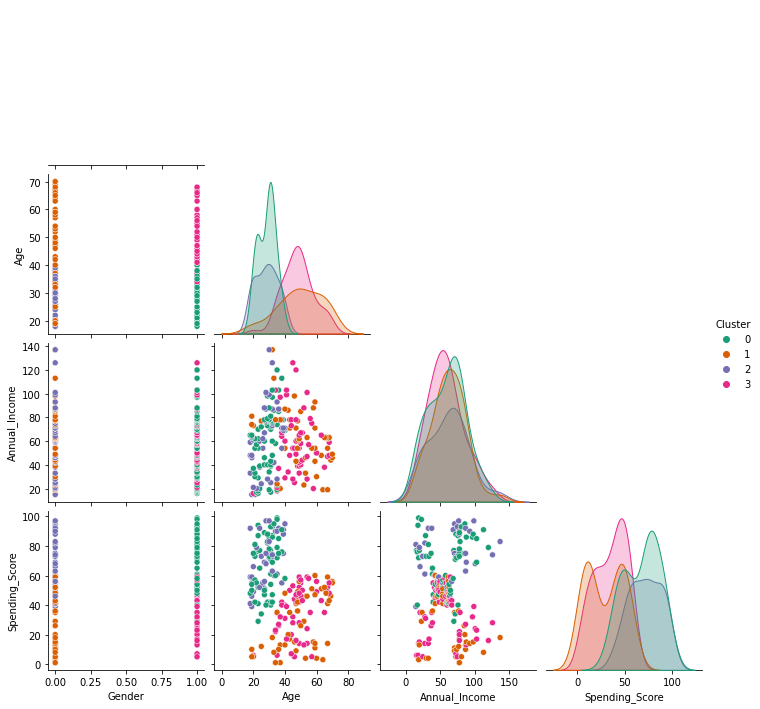

     Cluster        features  value
0          2          Gender      0
1          2          Gender      0
2          3          Gender      1
3          0          Gender      1
4          0          Gender      1
..       ...             ...    ...
795        0  Spending_Score     79
796        3  Spending_Score     28
797        2  Spending_Score     74
798        1  Spending_Score     18
799        2  Spending_Score     83

[800 rows x 3 columns]
         Gender        Age  Annual_Income  Spending_Score
Cluster                                                  
0           1.0  28.438596      59.666667       67.684211
1           0.0  49.437500      62.416667       29.208333
2           0.0  28.250000      62.000000       71.675000
3           1.0  48.109091      58.818182       34.781818
         Gender  Age  Annual_Income  Spending_Score
Cluster                                            
0             1   18             16              29
1             0   19             19     

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning:

92.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning:

11.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



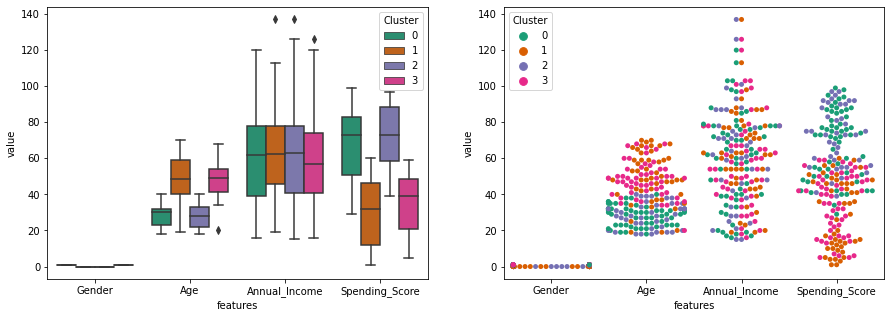

In [42]:
#Kmean with MinMax Normalisation Perform the best
df_seg = pd.concat([df_encode, Kmean_mm.label], axis = 1)
df_seg = df_seg.rename(columns={'label': 'Cluster'})
print(df_seg)
print(df_seg.Cluster.unique())
df_seg.info()

#plot Correlation
print('Data Correlation:')
plt.figure(figsize=(6,6))
sns.pairplot(df_seg, hue='Cluster', palette='Dark2', corner=True) 
plt.show()

df_seg_no_cluster = df_seg.drop(['Cluster'], axis=1)
df_cluster =  pd.concat([df_seg_no_cluster,df_seg['Cluster']], axis = 1)
df_seg_feature = pd.melt(df_cluster, 'Cluster', var_name="features")
print(df_seg_feature)

print(df_seg.groupby('Cluster').mean())
print(df_seg.groupby('Cluster').min())
print(df_seg.groupby('Cluster').max())

f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df_seg_feature, x="features", y='value', hue='Cluster', palette='Dark2', ax=ax1)
sns.swarmplot(data=df_seg_feature, x="features", y='value', hue='Cluster', palette='Dark2', ax=ax2)


In [43]:
df_seg_feature

,Cluster,features,value
0,2,Gender,0
1,2,Gender,0
2,3,Gender,1
3,0,Gender,1
4,0,Gender,1
...,...,...,...
795,0,Spending_Score,79
796,3,Spending_Score,28
797,2,Spending_Score,74
798,1,Spending_Score,18


In [44]:
df_seg['Cluster'].replace(to_replace=[0, 1, 2,3],
           value= ['0', '1', '2', '3'],
           inplace=True)

#scatter plot
df_seg_cluster = df_seg.copy()
class_dict = {'0':'Cluster0', 
              '1':'Cluster1',
              '2':'Cluster2',
              '3':'Cluster3'}
df_seg_cluster['Cluster'] = df_seg_cluster['Cluster'].map(class_dict)
fig7 = ff.create_scatterplotmatrix(df_seg_cluster, diag='histogram', index='Cluster',
                                  height=700, width=700,
                                  colormap= dict(
                                      Cluster0 = '#0D0888',
                                      Cluster1 = '#9D1A9F',
                                      Cluster2 = '#ED7953',
                                      Cluster3 = '#F5FB64'),
                                  colormap_type='cat',
                                  marker=dict(showscale=False, line_width=0.5)
                                  )
fig7.show()


#box plot
df_seg_no_cluster = df_seg_cluster.drop(['Cluster'], axis=1)
df_cluster =  pd.concat([df_seg_no_cluster,df_seg_cluster['Cluster']], axis = 1)
df_seg_feature = pd.melt(df_cluster, 'Cluster', var_name="features")
fig8 = px.box(df_seg_feature.sort_values(by=['Cluster'],ascending=False), x="features", y="value", color="Cluster",
             color_discrete_map={'Cluster0':'#0D0888',
                                 'Cluster1':'#9D1A9F',
                                 'Cluster2':'#ED7953',
                                 'Cluster3':'#F5FB64'}
            )
fig8.show()

#pie plot
df_seg_gen = df_seg_cluster.copy()
df_seg_gen = df_seg_gen.drop(columns='Gender')
df_seg_gen = pd.concat([df_seg_gen, df.Gender], axis = 1)
fig9 = px.sunburst(df_seg_gen, 
                  path=['Gender','Cluster'],
                  color='Cluster'
                  ,color_discrete_map={'(?)':'black','Cluster0':'#0D0888','Cluster1':'#9D1A9F','Cluster2':'#ED7953','Cluster3':'#F5FB64'}
                  )
fig9.show()

Task 4: Dash Plotly Dashboard

In [45]:
#merge---------------------
app = JupyterDash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP],
                  meta_tags=[
                      {
                      "name": "viewport",
                      "content": "width=device-width, initial-scale=1, maximum-scale=1",
                      }
                  ])
#color_dict
colors = {
          'main-background':'#eeeeee', #grey
          'background': '#fffff', #white
          'text': '#111111',
          'primary':'#0D0888'
         }
#card-------------------
card_content = [
    dbc.CardHeader("Card header", className="card-title"),
    dbc.CardBody([
        html.P("This is some card content that we'll reuse"
                ,className="card-text",)
    ])
]

#layout------------------------------------------------------------------------------------------------------------
app.layout = dbc.Container([
    #header
    dbc.Row(dbc.Col(html.H1('Customer Segmentation', className='text-center text-primary, mb-3'))),
    html.Hr(), 
    #title box 1
    dbc.Row(dbc.Col(
        html.Div(children=
        '''
        The goal of this customer segmentation is to put customers into groups with similar 
        characteristics, such as gender, age, annual income, and spending score. The segmentation
         includes data exploration, feature engineering, clustering, and analysis.
        ''',
        style={'background-color': 'background',
               'margin': '20px'},
        className='text-center fw-bold'
    ))),
    #graph row1
    dbc.Row([ 
        dbc.Col([  # 1R/1C
            html.H5('Gender Distribution', className='text-center'),
            dcc.Graph(id='graph1',
                      figure=fig2, 
                      style={'height':300})
            ],width={'size': 8, 'offset': 0, 'order': 1}),  
             
         dbc.Col([  # 1R/2C
            html.H5('Gender Ratio', className='text-center'),
            dcc.Graph(id='graph2',
                      figure=fig1,
                      style={'height':300})
            ], width={'size': 4, 'offset': 0, 'order': 2})
    ]),
    #description1
    dbc.Row([ 
        html.Div([
            html.P(
                  """Of the 200 records in the dataset, 56% are female customers and 44% are male. 
                  The mean age of all customers is 38.85 years, with an average annual income of $60.56 and a mean spending score of 50.20.
                   Male customers have a slightly higher mean age (39.80 years) and mean annual income ($59.25) compared to female customers (38.09 years and $51.52). Female customers have a higher mean spending score (51.52) compared to male customers (48.51). 
                  The most common age range among customers is 30-35 years, followed by those under 20 years and those between 45 and 50 years. The majority of customers have an income in the range of $50–62.5, followed by $75–87.5. The most common spending score among customers is 50-60, followed by 40-50.
                  """)
            ],style={
                    "width": "95%",
                    "display": "inline-block",
                    "margin-left": "20px",
                    "margin-right": "20px",
                    "margin-top": "20px",
                    "margin-bottom": "10px",
                    "text-indent": "35px",
                    "text-align": "justify",
                    "font-size":"14px"}
            )
    ]),
    #component1----------------------------------------------------------------
    dbc.Row([
        html.H5('Select Filter'),
        html.Hr(),
        dbc.Col([
            #dropdown gender
            html.H6('Customer Gender:'),
            dcc.Dropdown(
                multi=True,
                id='GenderSelect',
                options=[
                         {'label': x, 'value': x, 'disabled':False}
                         for x in df['Gender'].unique()
                ],
                value=['Female','Male'],
                style={'font-size': 15, 'padding-left': 10}
            ),
            html.Br(),
            #range slider
            html.H6('Age Range:'),
            dcc.RangeSlider(
                df['Age'].min(), df['Age'].max(), 5, 
                value=[18, 70],
                id='AgeSelect'
            ),            
        ],style={'marginLeft': '20px','marginRight': '20px'}),
        dbc.Col([
            html.Br(),
            #income slider
            html.H6('Income Range(K$):'),
            dcc.RangeSlider(
                df['Annual_Income'].min(), df['Annual_Income'].max(), 10, 
                value=[15, 137],
                id='Annual_IncomeSelect'
            ),
            #spending score slider
            html.H6('Spending Score:'),
            dcc.RangeSlider(
                df['Spending_Score'].min(), df['Spending_Score'].max(), 10, 
                value=[1, 99],
                id='Spending_ScoreSelect'
            )
        ],style={'marginLeft': '20px','marginRight': '20px'})
     ],style={'background-color': 'background',
              'paddingBottom': '20px'}),

    #--------------------------------------------------------------------------
    #graph row2
    dbc.Row([ 
         dbc.Col([  # 2R/1C
             html.H5('Scatterplot Matrix of Feature', className='text-center'),
             dcc.Graph(id='graph3',
                       figure=fig3,
                       style={'height':500}),
             ], width={'size': 8, 'offset': 0, 'order': 1}),
         dbc.Col([  # 2R/2C
             html.H5('Feature Correlation', className='text-center'),
             dcc.Graph(id='graph4',
                       figure=fig4,
                       style={'height':500}),
             ], width={'size': 4, 'offset': 0, 'order': 2})
    ]),
    #description2
    dbc.Row([
        html.Div(
             [html.P(
                      """ There is a strong positive correlation between the customer ID
                       and annual income (+0.98) and a negative correlation between age 
                       and spending score (-0.33). The correlation between gender and 
                       spending score is positive (+0.058), but there is no significant 
                       correlation in other features.
                      """
              )],
              style={
                      "width": "95%",
                      "display": "inline-block",
                      "margin-left": "20px",
                      "margin-right": "20px",
                      "margin-top": "20px",
                      "margin-bottom": "10px",
                      "text-indent": "35px",
                      "text-align": "justify",
                      "font-size":"14px"
                      },
        )
    ]),
    html.Hr(),
    #title box2
    dbc.Row([
       html.Div(children=
              '''
              To identify a different customer segment and underlie the similar characteristics 
              of their shopping behavior, an unsupervised learning algorithm will be applied to 
              distinguish clusters using a similarity measurement and the distance of the similarity function.
              ''',
              style={'background-color': 'background',
                    'margin': '20px'},
              className='text-center fw-bold'
              )
    ]),
    #graph3
    dbc.Row([ 
       dbc.Col([  # 3R/1C
              html.H5('DBSCAN Clustering', className='text-center'),
              dcc.Graph(id='graph5',
                          figure=fig5,
                          style={'height':500}),
       ]),
       dbc.Col([  # 3R/1C
              html.H5('K-means Clustering', className='text-center'),
              dcc.Graph(id='graph6',
                          figure=fig6,
                          style={'height':500})
       ])
    ]),
    dbc.Row([ 
        html.Div([
            html.H6('Feature Transformation:'),
            html.P(
                  """
                  As similarity measures can be easily affected by different scales, 
                  we apply Min-Max normalization to handle various magnitudes of numerical values.
                  """),
            html.H6('Dimensional Reduction:'),
            html.P(
                  """
                  To avoid the curse of the high-dimensional data, we use Principal
                  Component Analysis (PCA) with its explained variance ratio to evaluate the usefulness of each
                  number of principal components As a result, only useful information is extracted
                  into three-dimensional space.
                  """),   
            html.H6('The result between the K-mean and DBSCAN clustering:'),
            html.P(
                  """
                  The calculation of silhouette coefficient can validate the similarity measure of
                  the cluster from a cohesion within the same cluster (using average distance in the cluster) and
                  separation between different clusters (using the nearest cluster distance).
                  The visualization can indicate that the K-Means algorithm produces the best discriminative clusters
                  with a silhouette score of 0.78, whereas DBCAN can identify more sub-clusters with an outlier but 
                  is less effective at clustering various densities of data.
                  """),                
        ])
    ],style={
             "width": "95%",
             "display": "inline-block",
             "margin-left": "20px",
             "margin-right": "20px",
             "margin-top": "20px",
             "margin-bottom": "10px",
             "text-indent": "35px",
             "text-align": "justify",
             "font-size":"14px"}
    ),
    html.Hr(style={'margin-bottom': '10px'}),
    #title box3
    dbc.Row([
       html.Div(children='Cluster Analysis',
              style={'background-color': 'background',
                     'margin': '20px'},
              className='text-center fw-bold'
              )
    ]),
    dbc.Row([ 
        html.Div([
            html.P(
                  """The pair plot can indicate the relationship between each cluster and its feature attributes. 
                  The gender is the most significant part in segmentation, followed by age, but annual income
                  has no significance.
                  """)
            ],style={
                    "width": "95%",
                    "display": "inline-block",
                    "margin-left": "20px",
                    "margin-right": "20px",
                    "margin-top": "10px",
                    "margin-bottom": "10px",
                    "text-indent": "35px",
                    "text-align": "justify",
                    "font-size":"14px"}
            )
    ]),
    #component2----------------------------------------------------------------
    dbc.Row([
        html.H5('Select Filter'),
        html.Hr(),
        dbc.Col([
            html.H6('Customer Gender:'),
            dcc.Dropdown(
                multi=True,
                id='ClusterSelect',
                options=[
                         {'label': x, 'value': x, 'disabled':False}
                         for x in df_seg_cluster['Cluster'].unique()
                ],
                value=['Cluster0', 'Cluster1', 'Cluster2', 'Cluster3'],
                style={'font-size': 15, 'padding-left': 10}
            ),
        ]),
        dbc.Col([
            #spending score slider
            html.H6('Spending Score:'),
            dcc.RangeSlider(
                df['Spending_Score'].min(), df['Spending_Score'].max(), 10, 
                value=[1, 99],
                id='Spending_ScoreSelect2'
            )
        ],style={'marginLeft': '20px','marginRight': '20px'})    
    ],style={'background-color': 'background',
              'paddingBottom': '20px'}),
    #--------------------------------------------------------------------------
    #graph4
    dbc.Row([ 
        dbc.Col([ # 4R/1C
              html.H5('Scatterplot Matrix of Cluster', className='text-center'),
              dcc.Graph(id='graph7',
                        figure=fig7)
        ]),
        dbc.Col([
              dbc.Row([ # 4R/2C/1R
                  html.H5('Cluster Ratio', className='text-center'),
                  dcc.Graph(id='graph9',
                            figure=fig9,
                            style={'height':300})
              ]),
              dbc.Row([ # 4R/2C/1R
                  html.H5('Box Plot of Cluster', className='text-center'),
                  dcc.Graph(id='graph8',
                            figure=fig8,
                            style={'height':300})
              ])
        ]),
    ]),
    #card
    html.Div([
        dbc.Row([
            dbc.Col(dbc.Card([
              dbc.CardHeader("Cluster0", className="card-title",
                             style={'background':'#0D0888',
                                    'color':'white'}),
              dbc.CardBody([
                  html.P("""Cluster 0 is made up of males aged 19 to 70, with a mean age of 49. 
                        They have spending scores under 80, with a mean of 29.20, which is the 
                        lowest spending group.).
                        """,className="card-text ",
                         )
                  ])
              ],style={'border-color':'#0D0888',
                       'font-size':'14px'})),

            dbc.Col(dbc.Card([
              dbc.CardHeader("Cluster 1", className="card-title",
                             style={'background':'#9D1A9F',
                                    'color':'white'}),
              dbc.CardBody([
                  html.P("""Cluster 1 is made up of females aged 20 to 68, with a mean age of 48.
                        This group has spending scores under 59, with a mean of 34.78.
                        (This is the second-lowest spending group).
                        """,className="card-text",)
                  ])
              ],style={'border-color':'#9D1A9F',
                       'font-size':'14px'})),

            dbc.Col(dbc.Card([
              dbc.CardHeader("Cluster 2", className="card-title",
                             style={'background':'#ED7953',
                                    'color':'white'}),
              dbc.CardBody([
                  html.P("""Cluster2 are females aged 18-40 years old with a mean age of 28 
                        years old and have the spending scores of more than 29 with a mean of 
                        67.68, which is the second-highest spending group.
                        """,className="card-text",)
                  ])
              ],style={'border-color':'#ED7953',
                       'font-size':'14px'})),
            dbc.Col(dbc.Card([
              dbc.CardHeader("Cluster 3", className="card-title",
                             style={'background':'#F5FB64',
                                    'color':'black'}),
              dbc.CardBody([
                  html.P("""Cluster3 are males aged 18–40 years old with a mean age of 28. 
                        This group has the spending scores from 39-97 with a mean of 71.67, 
                        which is the highest spending group.
                        """,className="card-text",)
                  ])
              ],style={'border-color':'#F5FB64',
                       'font-size':'14px'})),
        ],className="mb-4",
          style={'margin': '20px'})
    ])

], fluid=True,
   style={'padding':'2rem', 
          'margin':'1rem', 
          'boxShadow': '#e3e3e3 4px 4px 2px', 
          'border-radius': '10px', 
          'marginTop': '2rem',
          'backgroundColor': colors['main-background']})

#callback filter1-----------------------------------------------------------------------
@app.callback(
    [Output('graph3', 'figure'),
    Output('graph4', 'figure')],

    [Input('GenderSelect', 'value'),
    Input('AgeSelect', 'value'),
    Input('Annual_IncomeSelect', 'value'),
    Input('Spending_ScoreSelect', 'value')
    ]
)
def update_graph(GenderSelect, AgeSelect, Annual_IncomeSelect, Spending_ScoreSelect):
  #update gender
  #ilter_df = df[ (df['Gender'].isin(GenderSelect)) & (df['Age'].isin(AgeSelect)) ] 
  filter_df = df[df['Gender'].isin(GenderSelect)] 
  filter_df = filter_df.loc[(AgeSelect[0] <= filter_df['Age']) & (AgeSelect[1] >= filter_df['Age'])]
  filter_df = filter_df.loc[(Annual_IncomeSelect[0] <= filter_df['Annual_Income']) & (Annual_IncomeSelect[1] >= filter_df['Annual_Income'])]
  filter_df = filter_df.loc[(Spending_ScoreSelect[0] <= filter_df['Spending_Score']) & (Spending_ScoreSelect[1] >= filter_df['Spending_Score'])]

  filter_df_encode = filter_df.copy()
  filter_df_encode['Gender']= filter_df_encode['Gender'].map(gender)

  fig3 = ff.create_scatterplotmatrix(filter_df, diag='histogram', index='Gender',
                                  height=500, width=800, 
                                  colormap= dict(
                                      Female = '#FF9900',
                                      Male = '#1616A7'),
                                  colormap_type='cat',
                                  marker=dict(line_color='white', line_width=0.5)
                                  )
  
  filter_df_corr = filter_df_encode.corr().round(2)
  mask = np.triu(np.ones_like(filter_df_corr, dtype=bool))
  fig4 = go.Figure()
  fig4.add_trace(go.Heatmap( x=list(filter_df_corr.index.values),
                             y=list(filter_df_corr.columns.values),
                             z= filter_df_corr.mask(mask).to_numpy(),
                             colorscale=px.colors.diverging.RdBu
                             ))
  fig4.update_layout(yaxis_autorange='reversed')
  return fig3, fig4

#callback filter2-----------------------------------------------------------------------
@app.callback(
    [Output('graph7', 'figure'),
     Output('graph8', 'figure'),
     Output('graph9', 'figure')],

    [Input('ClusterSelect', 'value'),
    # Input('AgeSelect2', 'value'),
    # Input('Annual_IncomeSelect2', 'value'),
     Input('Spending_ScoreSelect2', 'value')
    ]
)

def update_graph(ClusterSelect,Spending_ScoreSelect2):
  #update cluster
  filter_df_seg = df_seg_cluster[df_seg_cluster['Cluster'].isin(ClusterSelect)] 
  filter_df_seg_gen = df_seg_gen[df_seg_gen['Cluster'].isin(ClusterSelect)] 
  filter_df_seg_feature = df_seg_feature[df_seg_feature['Cluster'].isin(ClusterSelect)] 

  #update spending score
  filter_df_seg = filter_df_seg.loc[(Spending_ScoreSelect2[0] <= filter_df_seg['Spending_Score']) & (Spending_ScoreSelect2[1] >= filter_df_seg['Spending_Score'])]
  filter_df_seg_gen = filter_df_seg_gen.loc[(Spending_ScoreSelect2[0] <= filter_df_seg_gen['Spending_Score']) & (Spending_ScoreSelect2[1] >= filter_df_seg_gen['Spending_Score'])]


  fig7 = ff.create_scatterplotmatrix(filter_df_seg, diag='histogram', index='Cluster',
                                     height=700, width=700,
                                     colormap= dict(
                                         Cluster0 = '#0D0888',
                                         Cluster1 = '#9D1A9F',
                                         Cluster2 = '#ED7953',
                                         Cluster3 = '#F5FB64'),
                                     colormap_type='cat',
                                     marker=dict(showscale=False, line_width=0.5),
                                     )
  
  fig8 = px.box(filter_df_seg_feature.sort_values(by=['Cluster'],ascending=False), x="features", y="value", color="Cluster",
             color_discrete_map={'Cluster0':'#0D0888',
                                 'Cluster1':'#9D1A9F',
                                 'Cluster2':'#ED7953',
                                 'Cluster3':'#F5FB64'}
            )

  fig9 = px.sunburst(filter_df_seg_gen, 
                  path=['Gender','Cluster'],
                  color='Cluster'
                  ,color_discrete_map={'(?)':'black','Cluster0':'#0D0888','Cluster1':'#9D1A9F','Cluster2':'#ED7953','Cluster3':'#F5FB64'}
                  )
  
  return fig7, fig8, fig9
  
if __name__ == '__main__':
    app.run_server(mode='external')
    #app.run_server(mode='inline', port=8030)

Dash app running on:


<IPython.core.display.Javascript object>

Task 5: Deploy WebApps using ngrok



In [46]:
!pip install pyngrok
!ngrok authtoken 2K8Onntwdc8gyO0nVKVOO4xzF7S_67jANQSPHTkQAJQjsjcSs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [47]:
from pyngrok import ngrok
ngrok.kill()
public_url = ngrok.connect(8050, bind_tls=True)
public_url

<NgrokTunnel: "https://de8e-34-138-109-133.ngrok.io" -> "http://localhost:8050">